**NER**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from datetime import date, timedelta

import xgboost as xgb
from xgboost import plot_importance, plot_tree
import sklearn
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

import warnings
warnings.filterwarnings("ignore")

In [8]:
# raot_cta_ner = pd.read_csv('ner_data.csv')
raot_cta_ner = pd.read_csv('cta_ner_standard_deviation_msa.csv')
print(raot_cta_ner['PROPERTY_ID'].nunique())
raot_cta_ner.head()
print(raot_cta_ner.shape)

11920
(1221651, 14)


In [9]:
raot_cta_ner['WEEK_START'] = pd.to_datetime(raot_cta_ner['SURVEY_DATE']).dt.date
raot_cta_ner = raot_cta_ner.sort_values(by='WEEK_START')

# select rows where date is between given start/end date (inclusive)
start_date = pd.to_datetime('1/1/2015')
end_date = pd.to_datetime('8/14/2022')

raot_cta_ner = raot_cta_ner.loc[
    (raot_cta_ner['WEEK_START'] >= start_date) & (raot_cta_ner['WEEK_START'] <= end_date)]

In [10]:
def start_week_date(survey_date):
    start_date = survey_date - timedelta(days=survey_date.weekday())
    
    return start_date

raot_cta_ner['WEEK_START'] = raot_cta_ner.apply(lambda x: start_week_date(x['WEEK_START']), axis=1)
raot_cta_ner.tail()

,WEEK_START,PROPERTY_ID,SURVEY_ID,SURVEY_DATE,STATE,STATE_ID,MSA,MSA_ID,SUBMARKET,SUBMARKET_ID,NER,NER_T4,UNITS,UNITS_T4
518033,2022-08-08,602c20c37f74cc00030d7e8f,62f8494c3c85ac916425ffa8,2022-08-14,California,3e5ffbdd-4051-7165-7db7-21bdd14930db,"San Diego, CA",dfad4dd3-9313-6c18-50c1-0de9821b0d67,Vista,6cb2d14c09e8175b2af2a79a678b4f28,3191.593103,3109.348275,290.0,290.0
617496,2022-08-08,5e0663eaa41f7e001df91767,62f96fb8c433445bd07dd436,2022-08-14,North Carolina,3d798905-622e-7dd4-30d1-fa49906c6af0,"Charlotte, NC",09fd9026-18a1-a133-6510-17e3600a1c39,Harris Blvd/Mallard Creek Church Rd,a86c5516abb6853118fe5369f024627c,1637.105960,1516.932119,302.0,302.0
338967,2022-08-08,5cd08f0dce7ddb001540bbc4,62f95400ed9052c27d09bb2c,2022-08-14,Arizona,60682b07-6de7-18cc-618b-dfd375ec2200,"Phoenix, AZ",3593fab5-48d8-741f-9eeb-16a13099553c,South Tempe/Ahwatukee,631f1286def472f50e413889a1f6a6d7,1883.733333,1880.816666,300.0,300.0
576180,2022-08-08,5b004a206407dc00135180dd,62f97f5332ebcf0dc3370c23,2022-08-14,California,3e5ffbdd-4051-7165-7db7-21bdd14930db,"San Jose, CA",6e9d1acc-9171-a389-2994-fd1657f71fbe,Sunnyvale,eee20c797b9800c9bf98ceb2ec928b3c,3108.550913,3108.550913,766.0,766.0
518070,2022-08-08,61d76a6f85a40a002a0c469f,62f94c94eac34a852ab61739,2022-08-14,Oregon,bb3403f2-1a88-5959-3ee9-b369eab25b9a,"Portland, OR",1ac6ab71-5209-9f74-4e4b-f5a746648edb,Beaverton,c1b4899c4973474fa9b17a89deec49bf,2066.516129,2066.516129,124.0,124.0


In [11]:
raot_cta_ner = raot_cta_ner[['WEEK_START', 'PROPERTY_ID', 'STATE', 'MSA', 'SUBMARKET', 'NER_T4', 'UNITS_T4']]

In [12]:
from prophet import Prophet
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [13]:
class prophet_model:
    def __init__(self, algorithm_name, prediction_period):
        self.algorithm_name = algorithm_name
        self.prediction_period = prediction_period
        self.model = Prophet()
        
    def transformation(self, data, time_col, target_col):
        data[time_col] = pd.to_datetime(data[time_col])
        data.rename(columns={time_col:'ds', target_col:'y'}, inplace=True)
        
        data.drop(data.columns.difference(['ds','y']), 1, inplace=True)

        train_data = data[:-self.prediction_period]
        test_data = data[-self.prediction_period:]
        
        return train_data, test_data
    
    def fit_model(self, train_data):
        
        self.model.fit(train_data)
        return self.model
        
    def predict(self):
        future_data = self.model.make_future_dataframe(periods=self.prediction_period, freq='w')
        forecast = self.model.predict(future_data)
        predictions = forecast[['ds', 'yhat']][-self.prediction_period:]
        return predictions
    
    def evaluation(self, test_data, predictions):
        mae = mean_absolute_error(predictions['yhat'], test_data['y'])
        #print("mean_absolute_error on testing set:", mae)
        
        mape = mean_absolute_percentage_error(predictions['yhat'], test_data['y'])
        #print("mean_absolute_percentage_error on testing set:", mape)

        r_squared = r2_score(predictions['yhat'], test_data['y'])
        #print("r2_score on testing set:", r_squared)
        
        return mape
    
    def plot(self, test_data, predictions, label):
        plt.figure(figsize=(10, 5))
        plt.plot(test_data['ds'], test_data['y'], label = 'real data')
        plt.plot(predictions['ds'], predictions['yhat'], label = 'predictions')
        plt.legend()
        plt.title(f'Forecast vs Actuals for {label} with an error of {round(self.evaluation(test_data, predictions),3)}%')
        plt.show()
        
        return None
    
    
    def save_model(self, filename):    
        pickle.dump(self.model, open(filename, 'wb'))

17:28:16 - cmdstanpy - INFO - Chain [1] start processing
17:28:16 - cmdstanpy - INFO - Chain [1] done processing


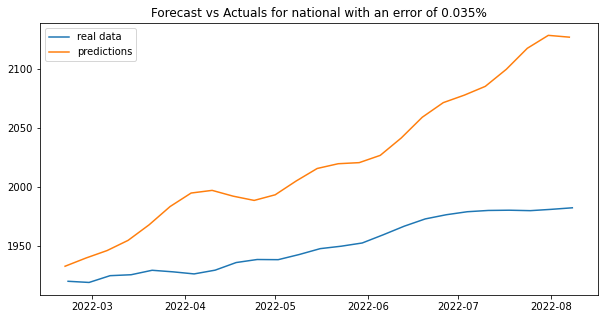

In [14]:
if __name__ == '__main__':
    avg_ner_data = raot_cta_ner.groupby(['WEEK_START']).agg({'UNITS_T4':'sum','NER_T4':'mean'}).reset_index()

    ## experimenting with a dataset
    prediction_period = 25
    algorithm_name = 'Prophet Model'
    
    results = prophet_model(algorithm_name, prediction_period)
    df_train, df_test = results.transformation(avg_ner_data, 'WEEK_START', 'NER_T4')
    results.fit_model(df_train)
    predictions = results.predict()
    results.evaluation(df_test, predictions)
    results.plot(df_test, predictions, 'national')

# MSA Level

In [15]:
msa_data = pd.read_csv('msa_data.csv')
msa_data_lst = list(msa_data['MSA'])

subsets = dict((x, y) for x, y in raot_cta_ner.groupby(['MSA']))

for unique_val, subset in subsets.items():
    subsets[unique_val] = subset.groupby('WEEK_START').mean('NER_T4').reset_index()

17:29:10 - cmdstanpy - INFO - Chain [1] start processing
17:29:10 - cmdstanpy - INFO - Chain [1] done processing


Atlanta, GA


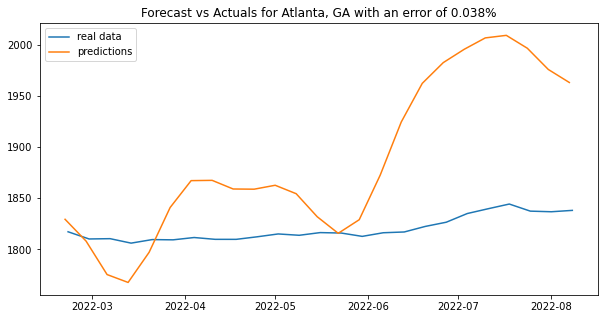

17:29:13 - cmdstanpy - INFO - Chain [1] start processing
17:29:13 - cmdstanpy - INFO - Chain [1] done processing


Austin, TX


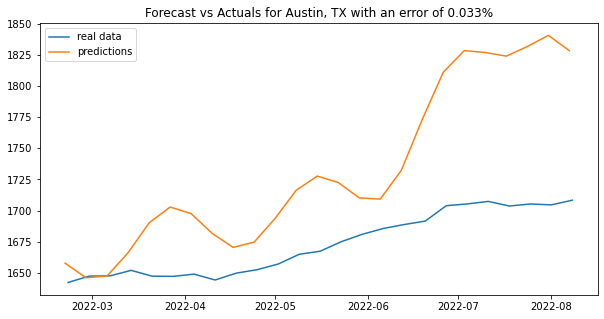

17:29:14 - cmdstanpy - INFO - Chain [1] start processing
17:29:14 - cmdstanpy - INFO - Chain [1] done processing


Baltimore, MD


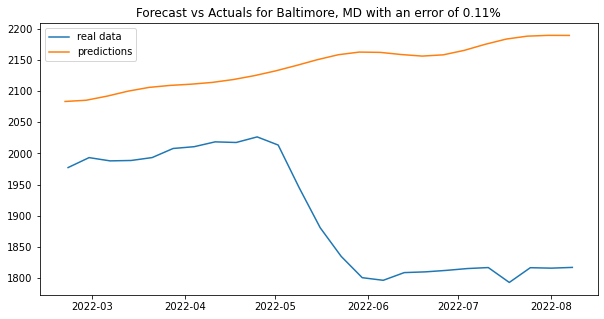

17:29:16 - cmdstanpy - INFO - Chain [1] start processing
17:29:16 - cmdstanpy - INFO - Chain [1] done processing


Boston, MA


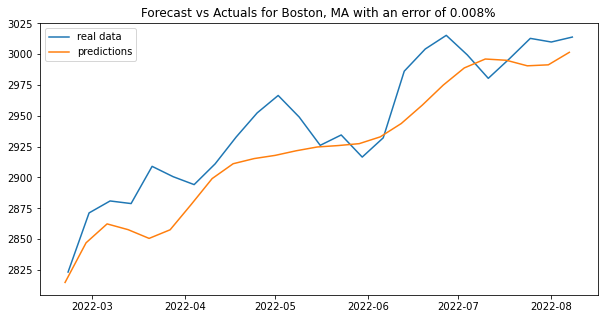

17:29:17 - cmdstanpy - INFO - Chain [1] start processing
17:29:17 - cmdstanpy - INFO - Chain [1] done processing


Charleston, SC


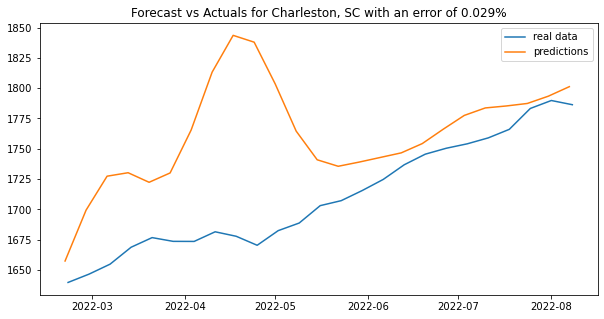

17:29:18 - cmdstanpy - INFO - Chain [1] start processing
17:29:18 - cmdstanpy - INFO - Chain [1] done processing


Charlotte, NC


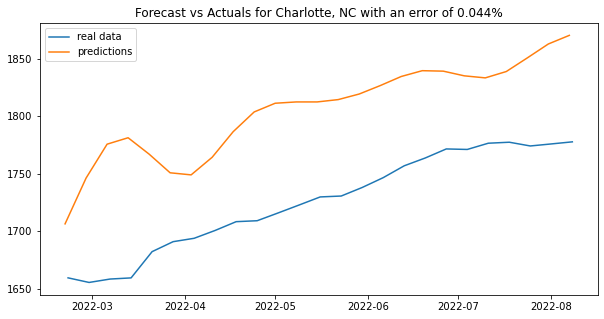

17:29:20 - cmdstanpy - INFO - Chain [1] start processing
17:29:20 - cmdstanpy - INFO - Chain [1] done processing


Chicago, IL


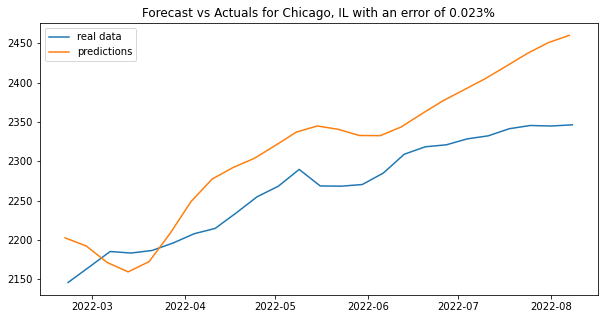

17:29:21 - cmdstanpy - INFO - Chain [1] start processing
17:29:21 - cmdstanpy - INFO - Chain [1] done processing


Dallas, TX


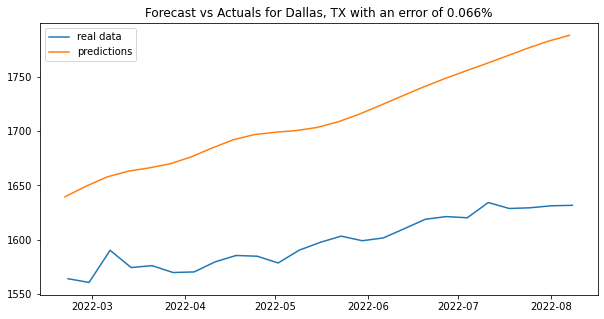

17:29:23 - cmdstanpy - INFO - Chain [1] start processing
17:29:23 - cmdstanpy - INFO - Chain [1] done processing


Denver, CO


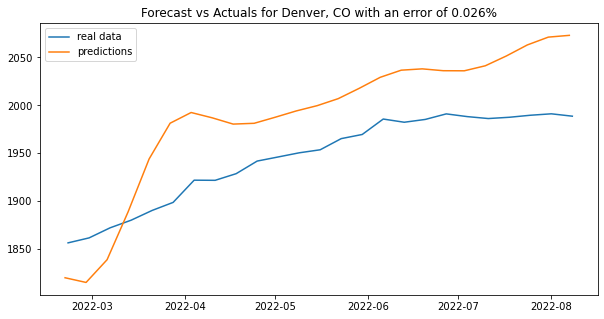

17:29:24 - cmdstanpy - INFO - Chain [1] start processing
17:29:24 - cmdstanpy - INFO - Chain [1] done processing


Houston, TX


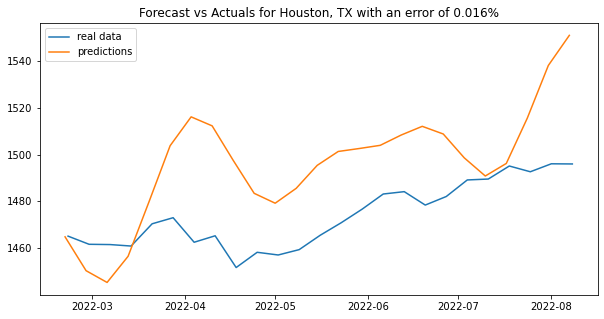

17:29:26 - cmdstanpy - INFO - Chain [1] start processing
17:29:26 - cmdstanpy - INFO - Chain [1] done processing


Jacksonville, FL


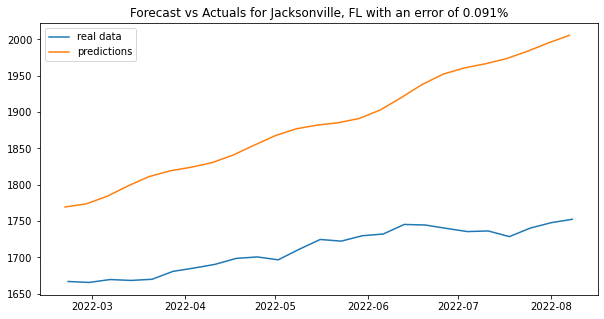

17:29:27 - cmdstanpy - INFO - Chain [1] start processing
17:29:28 - cmdstanpy - INFO - Chain [1] done processing


Las Vegas, NV


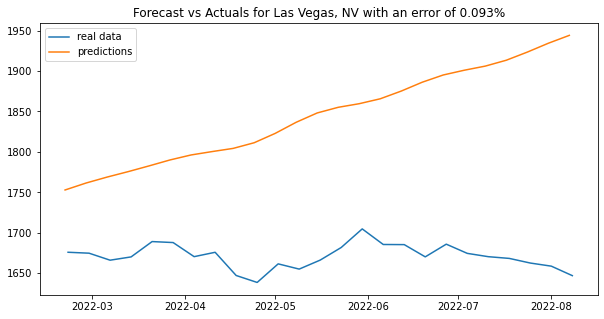

17:29:29 - cmdstanpy - INFO - Chain [1] start processing
17:29:29 - cmdstanpy - INFO - Chain [1] done processing


Los Angeles, CA


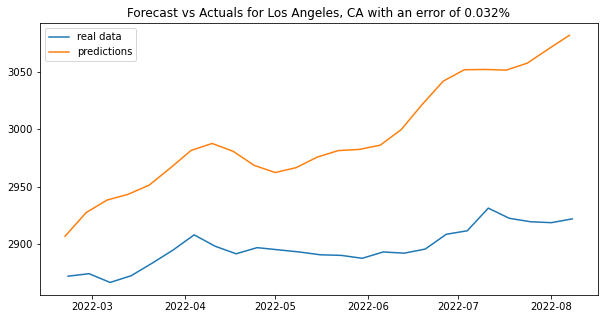

17:29:31 - cmdstanpy - INFO - Chain [1] start processing
17:29:31 - cmdstanpy - INFO - Chain [1] done processing


Miami, FL


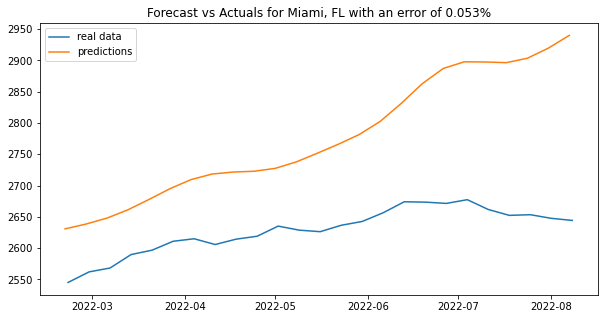

17:29:32 - cmdstanpy - INFO - Chain [1] start processing
17:29:32 - cmdstanpy - INFO - Chain [1] done processing


Nashville, TN


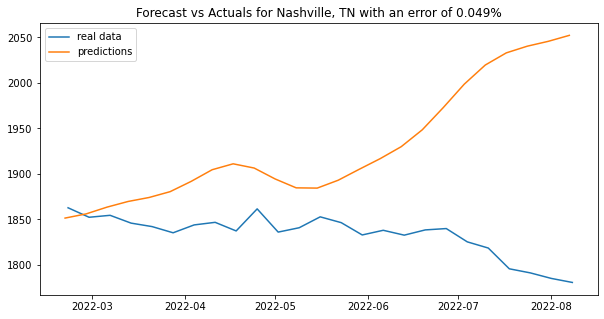

17:29:33 - cmdstanpy - INFO - Chain [1] start processing
17:29:34 - cmdstanpy - INFO - Chain [1] done processing


New York, NY


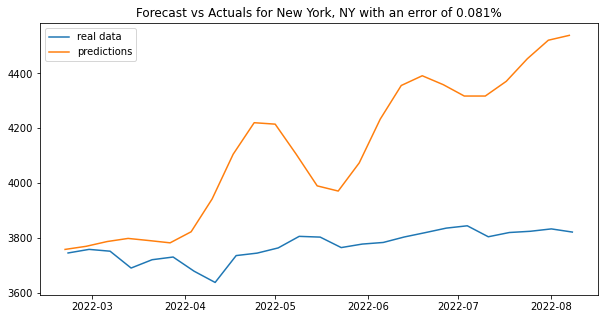

17:29:35 - cmdstanpy - INFO - Chain [1] start processing
17:29:35 - cmdstanpy - INFO - Chain [1] done processing


Orlando, FL


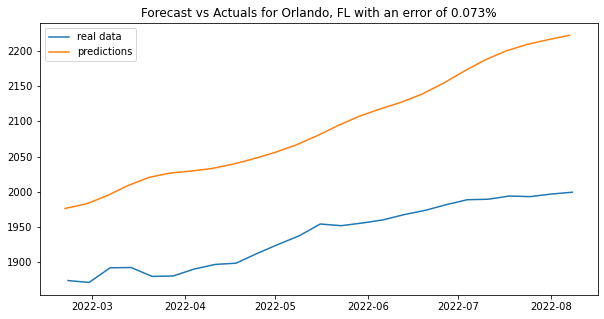

17:29:37 - cmdstanpy - INFO - Chain [1] start processing
17:29:37 - cmdstanpy - INFO - Chain [1] done processing


Phoenix, AZ


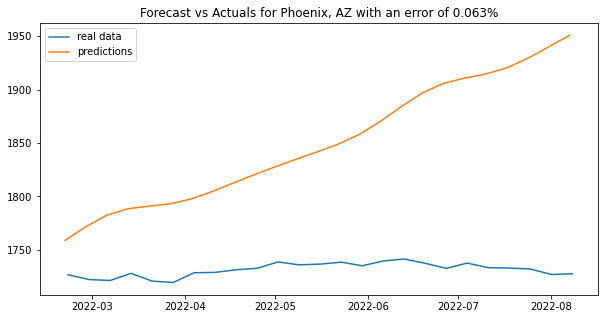

17:29:38 - cmdstanpy - INFO - Chain [1] start processing
17:29:38 - cmdstanpy - INFO - Chain [1] done processing


Portland, OR


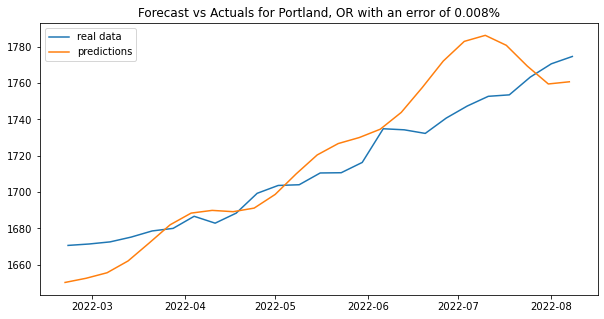

17:29:40 - cmdstanpy - INFO - Chain [1] start processing
17:29:40 - cmdstanpy - INFO - Chain [1] done processing


Raleigh, NC


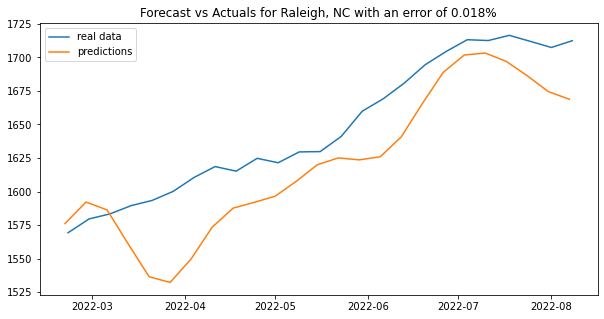

17:29:41 - cmdstanpy - INFO - Chain [1] start processing
17:29:41 - cmdstanpy - INFO - Chain [1] done processing


Riverside, CA


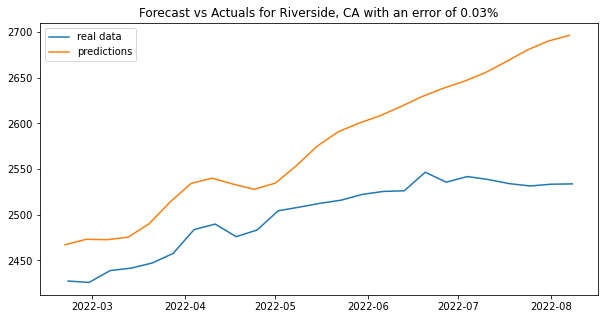

17:29:42 - cmdstanpy - INFO - Chain [1] start processing
17:29:42 - cmdstanpy - INFO - Chain [1] done processing


San Antonio, TX


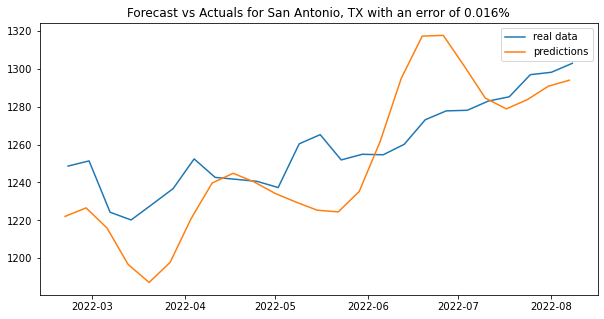

17:29:44 - cmdstanpy - INFO - Chain [1] start processing
17:29:44 - cmdstanpy - INFO - Chain [1] done processing


San Diego, CA


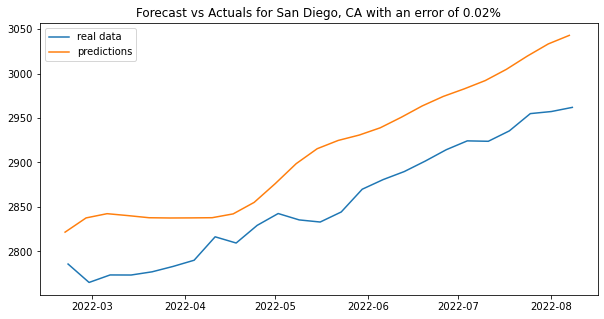

17:29:45 - cmdstanpy - INFO - Chain [1] start processing
17:29:45 - cmdstanpy - INFO - Chain [1] done processing


San Francisco, CA


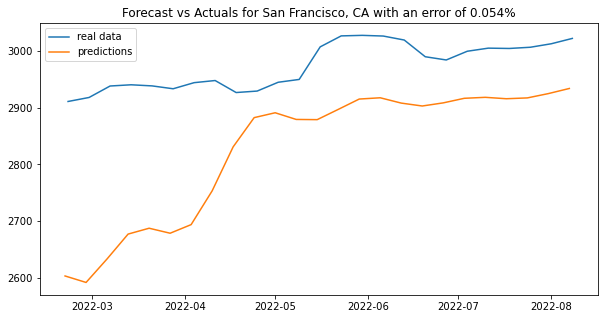

17:29:47 - cmdstanpy - INFO - Chain [1] start processing
17:29:47 - cmdstanpy - INFO - Chain [1] done processing


San Jose, CA


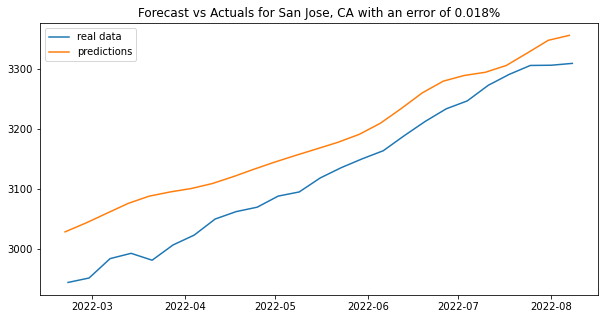

17:29:48 - cmdstanpy - INFO - Chain [1] start processing
17:29:48 - cmdstanpy - INFO - Chain [1] done processing


Seattle, WA


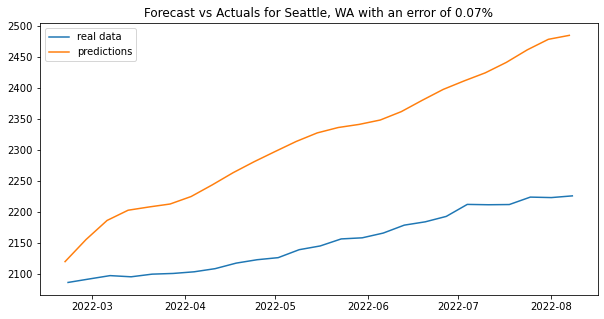

17:29:50 - cmdstanpy - INFO - Chain [1] start processing
17:29:50 - cmdstanpy - INFO - Chain [1] done processing


Tampa, FL


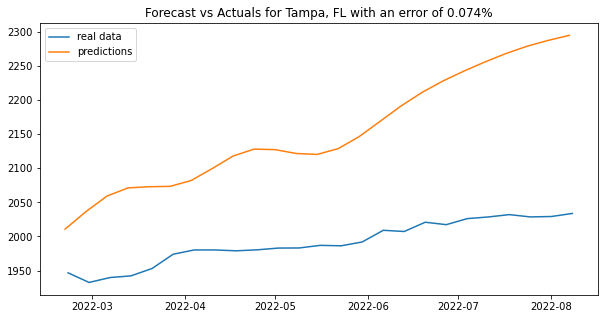

17:29:51 - cmdstanpy - INFO - Chain [1] start processing
17:29:51 - cmdstanpy - INFO - Chain [1] done processing


Washington, DC


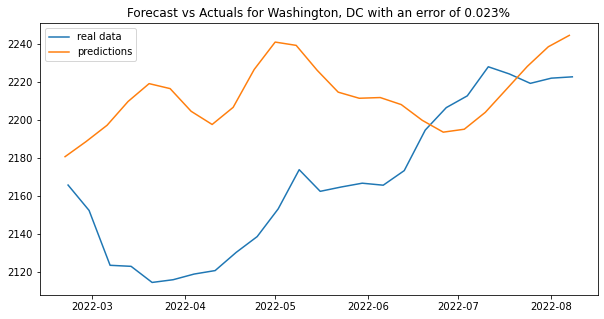

In [16]:
for unique_val, subset in subsets.items():
    if unique_val in msa_data_lst:
    
        ## experimenting with a dataset
        prediction_period = 25
        algorithm_name = 'Prophet Model'

        results = prophet_model(algorithm_name, prediction_period)
        print(unique_val)

        df_train, df_test = results.transformation(subset, 'WEEK_START', 'NER_T4')        
        
        results.fit_model(df_train)
        predictions = results.predict()
        results.evaluation(df_test, predictions)
        results.plot(df_test, predictions, unique_val)

**Extracting the data into a df**

In [17]:
msa_data = pd.read_csv('msa_data.csv')
msa_data_lst = list(msa_data['MSA'])

subsets = dict((x, y) for x, y in raot_cta_ner.groupby(['MSA']))

for unique_val, subset in subsets.items():
    subsets[unique_val] = subset.groupby('WEEK_START').mean('NER_T4').reset_index()

In [1]:
column_names = ["Model", "Time", "MSA", "Actuals", "Predictions", 'MAPE score']

df_prophet = pd.DataFrame(columns = column_names)
df_prophet

NameError: name 'pd' is not defined

In [ ]:
for unique_val, subset in subsets.items():
    if unique_val in msa_data_lst:
    
    
        column_names = ["Model", "Time", "MSA", "Actuals", "Predictions", 'MAPE score']

        df = pd.DataFrame(columns = column_names)
        df

        ## experimenting with a dataset
        prediction_period = 25
        algorithm_name = 'Prophet Model'

        results = prophet_model(algorithm_name, prediction_period)
        
        
        df_train, df_test = results.transformation(subset, 'WEEK_START', 'NER_T4')
        
        
        results.fit_model(df_train)
        predictions = results.predict()
        mape_score = results.evaluation(df_test, predictions)        
        df['Actuals'] =  df_test['y']
        df['Predictions'] =  predictions['yhat']
        df['MAPE score'] =  mape_score
        df['Time'] =  df_test['ds']
        df['Model'] =  algorithm_name
        df['MSA'] =  unique_val

        
        #results.evaluation(df_test, predictions)
        df_prophet = df_prophet.append(df, ignore_index=True)

In [3]:
pd.__version__
pip instsll

'1.2.5'

In [20]:
df_prophet

,Model,Time,MSA,Actuals,Predictions,MAPE score
0,Prophet Model,2022-02-21,"Atlanta, GA",1817.138120,1829.331045,0.037813
1,Prophet Model,2022-02-28,"Atlanta, GA",1810.117232,1808.024706,0.037813
2,Prophet Model,2022-03-07,"Atlanta, GA",1810.411329,1775.351378,0.037813
3,Prophet Model,2022-03-14,"Atlanta, GA",1806.048010,1767.650443,0.037813
4,Prophet Model,2022-03-21,"Atlanta, GA",1809.502624,1797.088271,0.037813
...,...,...,...,...,...,...
695,Prophet Model,2022-07-11,"Washington, DC",2227.980065,2203.994386,0.022595
696,Prophet Model,2022-07-18,"Washington, DC",2224.214343,2216.067743,0.022595
697,Prophet Model,2022-07-25,"Washington, DC",2219.253387,2228.176201,0.022595
698,Prophet Model,2022-08-01,"Washington, DC",2221.988182,2238.512780,0.022595


In [21]:
df_prophet.to_csv("df_prophet_msa_level_SAME_STORE.csv")

## State Level

In [10]:
subsets = dict((x, y) for x, y in raot_cta_ner.groupby(['STATE']))

for unique_val, subset in subsets.items():
    subsets[unique_val] = subset.groupby('WEEK_START').mean('NER').reset_index()

14:33:16 - cmdstanpy - INFO - Chain [1] start processing
14:33:17 - cmdstanpy - INFO - Chain [1] done processing


AL


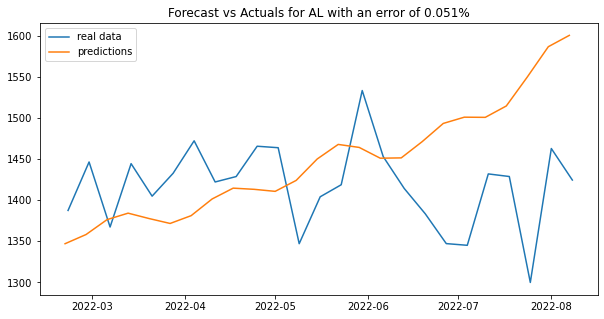

14:33:18 - cmdstanpy - INFO - Chain [1] start processing
14:33:18 - cmdstanpy - INFO - Chain [1] done processing


AR


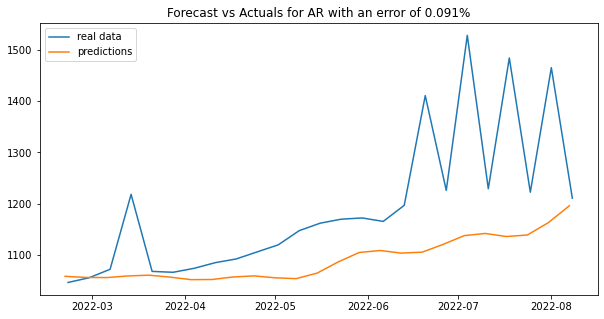

14:33:19 - cmdstanpy - INFO - Chain [1] start processing
14:33:19 - cmdstanpy - INFO - Chain [1] done processing


AZ


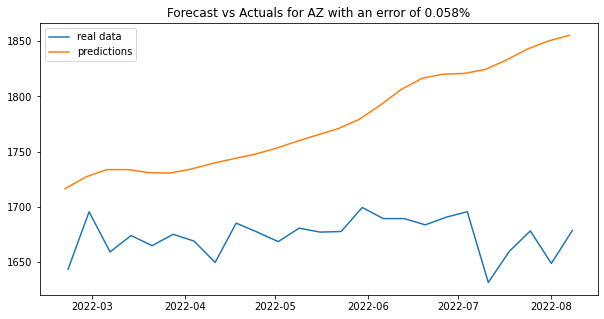

14:33:20 - cmdstanpy - INFO - Chain [1] start processing
14:33:20 - cmdstanpy - INFO - Chain [1] done processing


CA


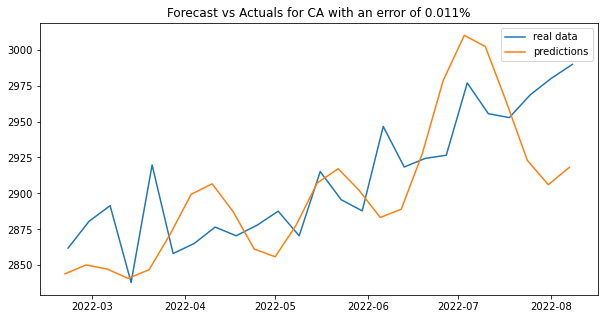

14:33:21 - cmdstanpy - INFO - Chain [1] start processing
14:33:21 - cmdstanpy - INFO - Chain [1] done processing


CO


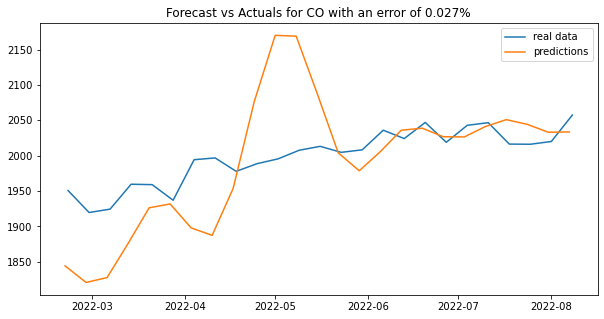

14:33:23 - cmdstanpy - INFO - Chain [1] start processing
14:33:23 - cmdstanpy - INFO - Chain [1] done processing


CT


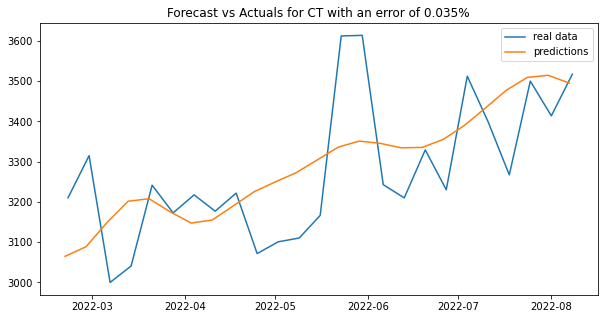

14:33:24 - cmdstanpy - INFO - Chain [1] start processing
14:33:24 - cmdstanpy - INFO - Chain [1] done processing


DC


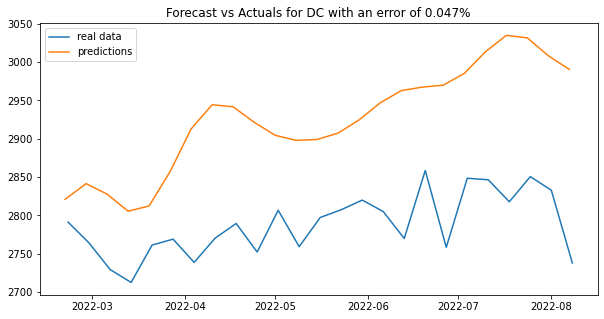

14:33:25 - cmdstanpy - INFO - Chain [1] start processing
14:33:25 - cmdstanpy - INFO - Chain [1] done processing


FL


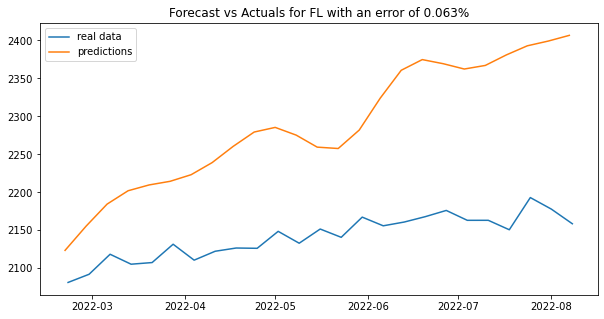

14:33:26 - cmdstanpy - INFO - Chain [1] start processing
14:33:26 - cmdstanpy - INFO - Chain [1] done processing


GA


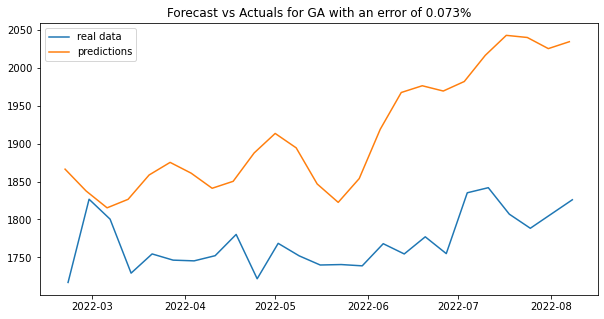

14:33:27 - cmdstanpy - INFO - Chain [1] start processing
14:33:28 - cmdstanpy - INFO - Chain [1] done processing


HI


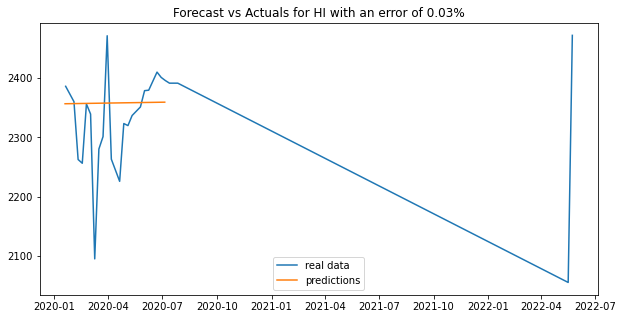

IA


ValueError: Dataframe has less than 2 non-NaN rows.

In [11]:
for unique_val, subset in subsets.items():
    
    ## experimenting with a dataset
    prediction_period = 25
    algorithm_name = 'Prophet Model'
    
    results = prophet_model(algorithm_name, prediction_period)
    print(unique_val)
    df_train, df_test = results.transformation(subset, 'WEEK_START', 'NER')
    
    results.fit_model(df_train)
    predictions = results.predict()
    results.evaluation(df_test, predictions)
    results.plot(df_test, predictions, unique_val)